# Q3 — PINNs para Elasticidade 2D (placa engastada e tracionada)

**Objetivo.** Implementar e treinar PINNs para dois cenários de elasticidade plana, reportando:
- arquitetura da rede e hiperparâmetros;
- definição das condições de contorno (soft × hard);
- gráficos de `u_x(x,y)` e `u_y(x,y)`;
- curva da **Loss Total** por épocas (fase Adam).

**Modelo físico (resumo).**  
Material isotrópico em 2D, módulo `E` e Poisson `ν`. Em equilíbrio e sem carga de corpo:
\[
\nabla\cdot \boldsymbol{\sigma} = \mathbf{0}, \quad
\boldsymbol{\sigma} = \lambda\, (\nabla\cdot \mathbf{u})\,\mathbf{I} + 2\mu\,\boldsymbol{\varepsilon}(\mathbf{u}),
\]
com `λ` e `μ` (parâmetros de Lamé) e `ε(u)` o gradiente simétrico.  
Domínio: `(x,y) ∈ (0,L)×(0,L)`. Unidades em **metros (m)**.

A seguir: setup, rede, operadores, perdas e os dois cenários:

- **Cenário A (BCs soft):** engastes em `x=0` e `y=0` (via loss Dirichlet) e tração `σxx=T` em `x=L`.  
- **Cenário B (BCs hard):** deslocamentos impostos por construção: `ux(0,y)=0`, `uy(x,0)=0` (trial); demais bordas livres.


In [9]:
# --- Imports & setup (PyTorch) ---
import math, time
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

# Precisão & dispositivo
torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(0); torch.manual_seed(0)

plt.rcParams.update({
    "figure.figsize": (6.6, 5.0),
    "axes.grid": True,
    "font.size": 12
})

def t(x):  # numpy -> torch no device escolhido
    return torch.as_tensor(x, dtype=torch.get_default_dtype(), device=device)

def print_block(title, d):
    print(f"\n{title}")
    for k, v in d.items():
        print(f" - {k}: {v}")


## Material, domínio e amostragem

- Parâmetros do material: módulo de Young `E`, coeficiente de Poisson `ν`, e Lamé `(λ, μ)`.
- Domínio: quadrado `(0,L)×(0,L)`.
- Amostragem de pontos: interior (PDE) e contornos (para BCs).


In [10]:
# --- Material & domínio ---
E  = 210e9
nu = 0.30
mu = E/(2*(1+nu))
lmbda = E*nu/((1+nu)*(1-2*nu))

L = 1.0  # m

print_block("Material/Geometria", {
    "E [Pa]": E, "nu": nu, "mu [Pa]": mu, "lambda [Pa]": lmbda, "L [m]": L
})

# --- Amostragem de pontos (interior e contorno) ---
def sample_interior(n):
    x = np.random.rand(n,1)*L
    y = np.random.rand(n,1)*L
    return t(np.hstack([x,y]))

def sample_boundary_x0(n):
    y = np.random.rand(n,1)*L
    x = np.zeros_like(y)
    return t(np.hstack([x,y]))

def sample_boundary_xL(n):
    y = np.random.rand(n,1)*L
    x = np.full_like(y, L)
    return t(np.hstack([x,y]))

def sample_grid(nx=101, ny=101):
    xs = np.linspace(0, L, nx)
    ys = np.linspace(0, L, ny)
    XX, YY = np.meshgrid(xs, ys)
    XY = np.stack([XX.ravel(), YY.ravel()], axis=1)
    return t(XY), XX, YY



Material/Geometria
 - E [Pa]: 210000000000.0
 - nu: 0.3
 - mu [Pa]: 80769230769.23077
 - lambda [Pa]: 121153846153.84615
 - L [m]: 1.0


## Rede, operadores e PDE

- Rede FNN com ativação `tanh`.
- TrialNet (cenário B) impõe BCs **hard**: `ux=(x/L)*N1`, `uy=(y/L)*N2`.
- Operadores via Autograd para obter gradientes de `u` e tensões `σ`.
- Resíduos de equilíbrio: `div σ = 0` (duas equações).


In [11]:
# --- FNN básica ---
class FNN(nn.Module):
    def __init__(self, layers, act=nn.Tanh):
        super().__init__()
        net = []
        for i in range(len(layers)-2):
            net += [nn.Linear(layers[i], layers[i+1]), act()]
        net += [nn.Linear(layers[-2], layers[-1])]
        self.net = nn.Sequential(*net)
    def forward(self, x):
        return self.net(x)

# --- Trial para BC hard (usado no Cenário B) ---
class TrialNet(nn.Module):
    # Impõe ux(0,y)=0 e uy(x,0)=0 por construção:
    # ux = (x/L) * N1,  uy = (y/L) * N2
    def __init__(self, base):
        super().__init__()
        self.base = base
    def forward(self, XY):
        out = self.base(XY)
        N1 = out[...,0:1]
        N2 = out[...,1:2]
        x = XY[...,0:1]; y = XY[...,1:2]
        ux = (x/L) * N1
        uy = (y/L) * N2
        return torch.cat([ux, uy], dim=-1)

# --- Operadores e PDE ---
def grads(u, XY):
    du = torch.autograd.grad(u, XY, grad_outputs=torch.ones_like(u),
                             create_graph=True, retain_graph=True)[0]
    return du[...,0:1], du[...,1:2]  # du/dx, du/dy

def elasticity_residual(model, XY):
    XY.requires_grad_(True)
    u = model(XY)
    ux = u[...,0:1]; uy = u[...,1:2]

    ux_x, ux_y = grads(ux, XY)
    uy_x, uy_y = grads(uy, XY)
    divu = ux_x + uy_y

    sxx = lmbda*divu + 2*mu*ux_x
    syy = lmbda*divu + 2*mu*uy_y
    sxy = mu*(ux_y + uy_x)

    sxx_x, _     = grads(sxx, XY)
    _,     sxy_y = grads(sxy, XY)
    sxy_x, _     = grads(sxy, XY)
    _,     syy_y = grads(syy, XY)

    r1 = sxx_x + sxy_y
    r2 = sxy_x + syy_y
    return r1, r2, (sxx, syy, sxy)


## Funções de perda e otimizadores

- `Loss PDE`: média dos resíduos ao quadrado.  
- `Dirichlet (soft)`: erro quadrático entre `u` e alvo no contorno.  
- `Tração`: erro entre tensões de superfície e valor prescrito (ex.: `σxx=T` em `x=L`).  
- Treinamento em duas fases: **Adam** (aquecimento) → **L‑BFGS** (refino).


In [12]:
# --- Perdas ---
def loss_pde(model, XYi):
    r1, r2, _ = elasticity_residual(model, XYi)
    return (r1.pow(2).mean() + r2.pow(2).mean())

def loss_dirichlet_u(model, XYb, target):
    u = model(XYb)
    return (u - target).pow(2).mean()

def loss_traction_xL(model, XYb, Tx=1e6, Ty=0.0):
    XYb.requires_grad_(True)
    _, _, (sxx, _, sxy) = elasticity_residual(model, XYb)
    return (sxx - Tx).pow(2).mean() + (sxy - Ty).pow(2).mean()

# --- Treinos: Adam -> L-BFGS ---
def train_adam(model, loss_fn, iters=2000, lr=1e-3, every=200):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    hist = []
    t0 = time.time()
    for k in range(1, iters+1):
        opt.zero_grad()
        loss = loss_fn()
        loss.backward()
        opt.step()
        hist.append(loss.item())
        if k % every == 0 or k == 1:
            print(f"[Adam] it {k:5d}  loss={loss.item():.3e}")
    print(f"'Adam' levou {time.time()-t0:.1f} s")
    return np.array(hist)

def train_lbfgs(model, loss_fn, max_iter=150):
    opt = torch.optim.LBFGS(model.parameters(),
                            max_iter=max_iter, history_size=50,
                            line_search_fn="strong_wolfe")
    t0 = time.time()
    def closure():
        opt.zero_grad(set_to_none=True)
        loss = loss_fn()
        loss.backward()
        return loss
    loss = opt.step(closure)
    print(f"'L-BFGS' levou {time.time()-t0:.1f} s | loss final={float(loss):.3e}")


## Cenário A — BCs *soft*

**BCs e parâmetros.**
- Engastes: `x=0` ⇒ `ux=0, uy=0` (Dirichlet soft); `y=0` ⇒ `uy=0` (base engastada apenas em y).
- Tração: `σxx=T` em `x=L` (Neumann soft), com `T=1e6 Pa`.
- Rede: FNN `[2, 32, 32, 2]` com `tanh` (pode aumentar para `[2,64,64,64,2]`).
- Pontos: interior `N=1500`, contorno `N=200`.
- Otimização: Adam (`lr=1e-3`, `2000` épocas) → L‑BFGS (`150` iterações).

**Saídas.** Campos `ux(x,y)`, `uy(x,y)` e curva da *Loss Total* (fase Adam).



Rede (A)
 - camadas: [2, 32, 32, 2]
 - ativação: tanh

Treino (A)
 - pontos interior: 1500
 - pontos contorno: 200
 - Adam: lr=1e-3, iters=2000
 - L-BFGS: max_iter=150
 - BCs: soft (Dirichlet + tração)
[Adam] it     1  loss=2.437e+21
[Adam] it   200  loss=7.820e+17
[Adam] it   400  loss=2.381e+17
[Adam] it   600  loss=1.334e+17
[Adam] it   800  loss=9.780e+16
[Adam] it  1000  loss=7.681e+16
[Adam] it  1200  loss=6.094e+16
[Adam] it  1400  loss=4.834e+16
[Adam] it  1600  loss=3.837e+16
[Adam] it  1800  loss=3.061e+16
[Adam] it  2000  loss=2.470e+16
'Adam' levou 85.8 s
'L-BFGS' levou 7.3 s | loss final=2.467e+16


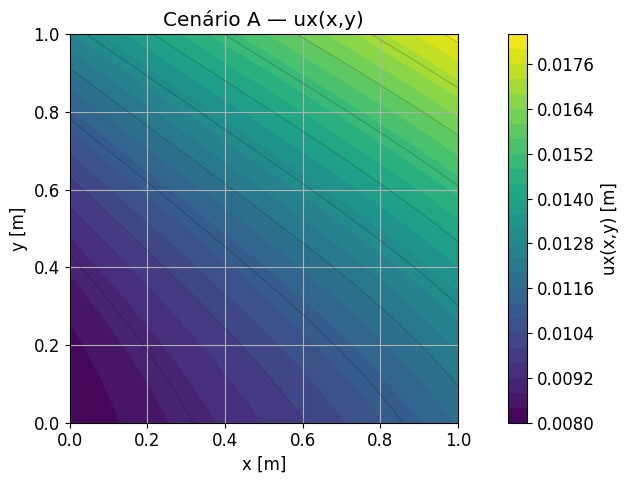

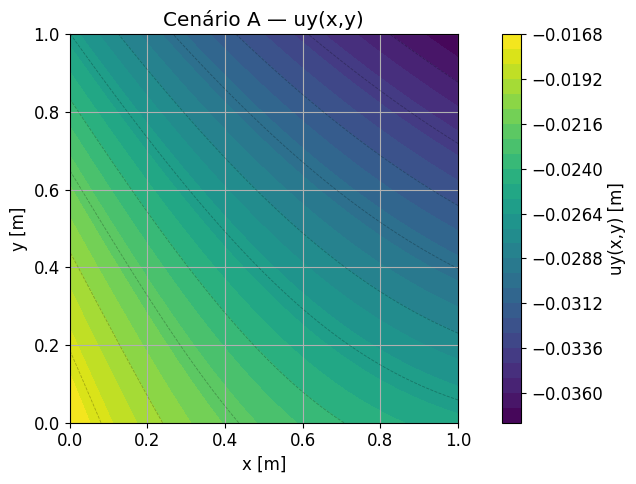

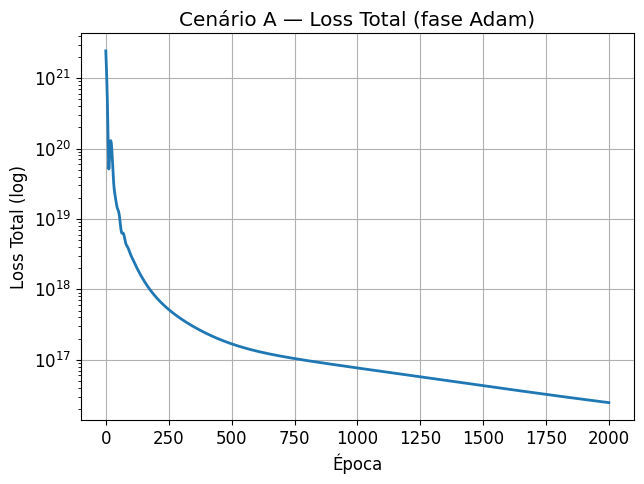

In [13]:
# --- Hiperparâmetros "rápidos" (CPU) ---
layers_A = [2, 32, 32, 2]  # pode aumentar para [2,64,64,64,2]
Nint, Nb = 1500, 200
Tval = 1e6  # Pa

# Rede
netA = FNN(layers_A).to(device)

# Pontos
XYi  = sample_interior(Nint).to(device)
XYx0 = sample_boundary_x0(Nb).to(device)  # x=0
XYxL = sample_boundary_xL(Nb).to(device)  # x=L
# borda inferior (y=0): impomos u_y=0 (engaste em y)
XYy0 = t(np.hstack([np.random.rand(Nb,1)*L, np.zeros((Nb,1))])).to(device)

print_block("Rede (A)", {"camadas": layers_A, "ativação": "tanh"})
print_block("Treino (A)", {
    "pontos interior": Nint, "pontos contorno": Nb,
    "Adam": "lr=1e-3, iters=2000", "L-BFGS": "max_iter=150",
    "BCs": "soft (Dirichlet + tração)"
})

# Loss total do Cenário A
def loss_total_A():
    lpde = loss_pde(netA, XYi)
    ldir_x0 = loss_dirichlet_u(netA, XYx0, target=t(np.zeros((Nb,2))).to(device))         # ux=0, uy=0 em x=0
    # em y=0: apenas uy=0 (mantém ux livre na base; ajuste se quiser ux=0 também)
    u_y0 = netA(XYy0)
    ldir_y0 = (u_y0[...,1:2] - 0.0).pow(2).mean()
    ltrac = loss_traction_xL(netA, XYxL, Tx=Tval, Ty=0.0)                                # tração em x=L
    return lpde + ldir_x0 + ldir_y0 + ltrac

# Treino
histA = train_adam(netA, loss_total_A, iters=2000, lr=1e-3, every=200)
train_lbfgs(netA, loss_total_A, max_iter=150)

# Grade para visualizar + função de plot
XYg, XX, YY = sample_grid(101,101)
XYg = XYg.to(device)
with torch.no_grad():
    Ug = netA(XYg).cpu().numpy()
UX_A = Ug[:,0].reshape(YY.shape)
UY_A = Ug[:,1].reshape(YY.shape)

def plot_field(Z, XX, YY, title, unit="m", cmap="viridis"):
    plt.figure()
    cp = plt.contourf(XX, YY, Z, levels=30, cmap=cmap)
    cbar = plt.colorbar(cp)
    cbar.set_label(f"{title.split('—')[-1].strip()} [{unit}]")
    plt.contour(XX, YY, Z, levels=10, colors="k", alpha=0.25, linewidths=0.6)
    plt.xlabel("x [m]"); plt.ylabel("y [m]")
    plt.title(title); plt.axis("scaled")
    plt.tight_layout(); plt.show()

plot_field(UX_A, XX, YY, "Cenário A — ux(x,y)")
plot_field(UY_A, XX, YY, "Cenário A — uy(x,y)")

plt.figure()
plt.semilogy(histA, lw=2)
plt.xlabel("Época"); plt.ylabel("Loss Total (log)")
plt.title("Cenário A — Loss Total (fase Adam)")
plt.tight_layout(); plt.show()


## Cenário B — BCs *hard* (trial)

**BCs e parâmetros.**
- Deslocamentos impostos **por construção** (trial): `ux(0,y)=0` e `uy(x,0)=0`.  
- Demais bordas livres.
- Rede (base): FNN `[2, 32, 32, 2]` com `tanh`, embutida na `TrialNet`.
- Pontos de interior: `1500`.
- Otimização: Adam (`lr=1e-3`, `2000` épocas) → L‑BFGS (`150` iterações).

**Saídas.** Campos `ux(x,y)`, `uy(x,y)` e curva da *Loss Total* (fase Adam).



Rede (B)
 - base: [2, 32, 32, 2]
 - ativação: tanh
 - trial: ux=(x/L)*N1, uy=(y/L)*N2

Treino (B)
 - pontos interior: 1500
 - Adam: lr=1e-3, iters=2000
 - L-BFGS: max_iter=150
 - BC desloc.: hard (trial)
[Adam] it     1  loss=9.998e+21
[Adam] it   200  loss=1.389e+18
[Adam] it   400  loss=5.308e+17
[Adam] it   600  loss=3.211e+17
[Adam] it   800  loss=2.287e+17
[Adam] it  1000  loss=1.812e+17
[Adam] it  1200  loss=1.510e+17
[Adam] it  1400  loss=1.284e+17
[Adam] it  1600  loss=1.097e+17
[Adam] it  1800  loss=9.334e+16
[Adam] it  2000  loss=7.883e+16
'Adam' levou 92.8 s
'L-BFGS' levou 7.7 s | loss final=7.876e+16


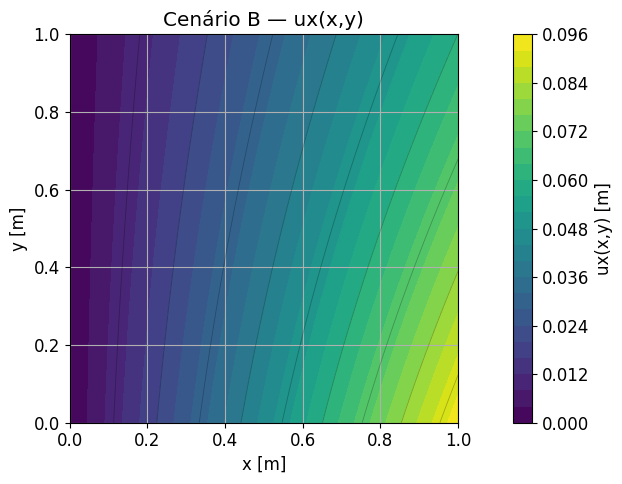

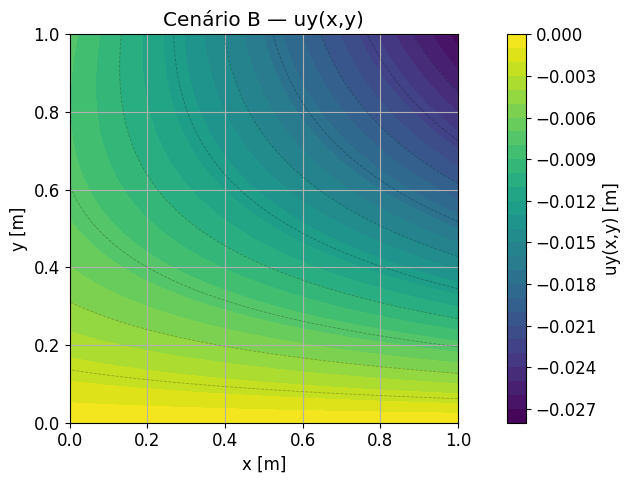

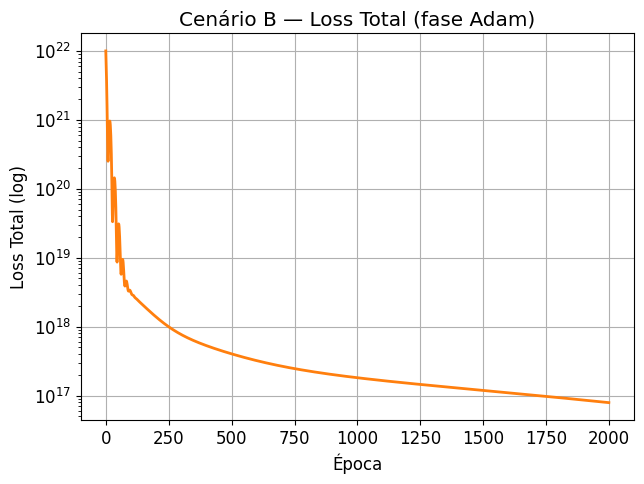

In [14]:
layers_B = [2, 32, 32, 2]
baseB = FNN(layers_B).to(device)
netB  = TrialNet(baseB).to(device)

NintB = 1500
XYiB = sample_interior(NintB).to(device)

print_block("Rede (B)", {
    "base": layers_B, "ativação": "tanh",
    "trial": "ux=(x/L)*N1, uy=(y/L)*N2"
})
print_block("Treino (B)", {
    "pontos interior": NintB, "Adam": "lr=1e-3, iters=2000",
    "L-BFGS": "max_iter=150", "BC desloc.": "hard (trial)"
})

def loss_total_B():
    return loss_pde(netB, XYiB)

histB = train_adam(netB, loss_total_B, iters=2000, lr=1e-3, every=200)
train_lbfgs(netB, loss_total_B, max_iter=150)

with torch.no_grad():
    Ub = netB(XYg).cpu().numpy()
UX_B = Ub[:,0].reshape(YY.shape)
UY_B = Ub[:,1].reshape(YY.shape)

plot_field(UX_B, XX, YY, "Cenário B — ux(x,y)")
plot_field(UY_B, XX, YY, "Cenário B — uy(x,y)")

plt.figure()
plt.semilogy(histB, lw=2, color="tab:orange")
plt.xlabel("Época"); plt.ylabel("Loss Total (log)")
plt.title("Cenário B — Loss Total (fase Adam)")
plt.tight_layout(); plt.show()


## Observações finais

- **Arquitetura**: FNN totalmente conectada com `tanh`; entrada `(x,y)`, saída `(ux,uy)`.  
- **Parâmetros**:
  - *Adam* `lr=1e-3`, `2000` épocas; *L‑BFGS* `max_iter=150`.  
  - Pontos: interior `1500`; contorno `200` (apenas no Cenário A).  
- **BCs**:
  - **A (soft)**: `ux=0, uy=0` em `x=0`, `uy=0` em `y=0` e tração `σxx=T` em `x=L` — todos via termos de **loss**.  
  - **B (hard)**: `ux(0,y)=0` e `uy(x,0)=0` por construção (trial).  
- **Gráficos**: mapas de `ux` e `uy` mostram campos coerentes com o problema físico; curva de loss ilustra convergência na fase *Adam*.  
- **Aprimoramentos**: para maior fidelidade, aumentar camadas/neurônios, número de pontos e iterações; preferir **GPU** no Colab; usar **normalização** de variáveis para estabilizar a magnitude da loss.